In [1]:
import math 
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
def f(x):
    return 3*x**2 - 4*x+5 # Derivative of this is 6x-4 

In [3]:
f(3.0)

20.0

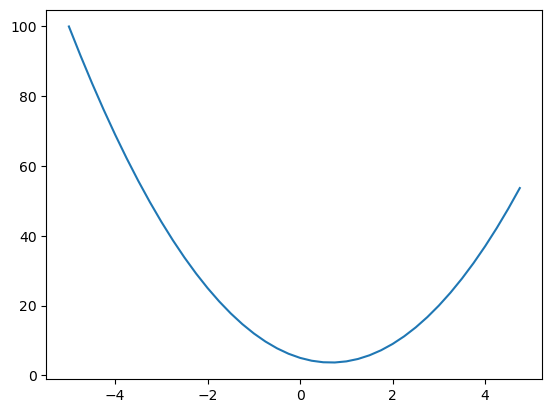

In [4]:
xs = np.arange(-5, 5, 0.25)
ys = f(xs)
plt.plot(xs, ys)
plt.show()

## What is the derivative of this function at any point of x?
You will not write the derivative code.

Derivative means if we slightly change x by a value h, how will the function respond?
If h is too small, the slope will become 0  

In [5]:
h = 0.00001
x = 2/3
print(f(x))
print(f(x+h))
print(f(x+h) - f(x)) #This is how much the function responded in the positive direction
print((f(x+h) - f(x)) / h) # And this is the numerical approximation of the slope

3.666666666666667
3.666666666966667
3.000000248221113e-10
3.0000002482211127e-05


In [6]:
# Let's get more complex
a = 2.0
b = -3.0
c = 10.0
d = a*b+c
print(d)

4.0


In [7]:
h = 0.0001
#inputs
a = 2.0
b = -3.0
c = 10.0

d1 = a * b + c
a+=h
d2 = a * b + c
print('d1', d1)
print('d2', d2)
print('Slope', (d2 -d1)/h) # Slope will be negative cause d2 is less than d1

d1 4.0
d2 3.999699999999999
Slope -3.000000000010772


In [8]:
# same as above but we are increasing b by h
h = 0.0001
#inputs
a = 2.0
b = -3.0
c = 10.0

d1 = a * b + c
b+=h
d2 = a * b + c
print('d1', d1)
print('d2', d2)
print('Slope', (d2 -d1)/h) # Slope will be negative cause d2 is less than d1

d1 4.0
d2 4.0002
Slope 2.0000000000042206


In [9]:
# same as above but we are increasing c by h
h = 0.0001
#inputs
a = 2.0
b = -3.0
c = 10.0

d1 = a * b + c
c+=h
d2 = a * b + c
print('d1', d1)
print('d2', d2)
print('Slope', (d2 -d1)/h) # Slope will be negative cause d2 is less than d1

d1 4.0
d2 4.0001
Slope 0.9999999999976694


## Starting the core Value object of micrograd and its visualization 

In [10]:
class Value:
    def __init__(self, data, _children=(), _op='', label=''):
        self.data = data
        self.grad = 0.0
        self._backward = lambda: None
        self._prev = set(_children)
        self._op = _op
        self.label = label
    
    def __repr__(self):
        return f"Value(data={self.data})" #without this function, you would have to 
        #access the data separately for each object

    def __add__(self, other):
        other = other if isinstance(other,Value) else Value(other)
        out = Value(self.data + other.data, (self, other), '+')
        def _backward():
            self.grad += 1.0 * out.grad
            other.grad += 1.0 * out.grad
        out._backward = _backward
        return out

    def __mul__(self, other):
        other = other if isinstance(other,Value) else Value(other)
        out = Value(self.data * other.data, (self, other), '*')
        def _backward():
            self.grad += other.data * out.grad
            other.grad += self.data * out.grad
        out._backward = _backward
        return out

    def __pow__(self, other):
        assert isinstance(other, (int, float)), "only for supporting int/float popwers for now"
        out = Value(self.data**other, (self,), f"**{other}")
        def _backward():
            self.grad += other * (self.data**(other-1)) * out.grad
        out._backward = _backward
        return out

    def __radd__self(self, other):
        return self + other
    
    def __rmul__(self,other):
        return self * other

    def __truediv__(self, other):
        return self * other**-1

    def __neg__(self):
        return self * -1

    def __sub__(self, other):
        return self + (-other)

    def tanh(self):
        x = self.data
        t = (math.exp(2*x) - 1) / (math.exp(2*x) + 1) 
        out = Value(t, (self, ), 'tanh')
        def _backward():
            self.grad += (1 - t**2) * out.grad 
        out._backward = _backward
        return out

    def exp(self):
        x = self.data
        out = Value(math.exp(x), (self,), 'exp')
        def _backward():
            self.grad += out.data * out.grad
        out._backward = _backward
        return out

    def backward(self):
        # Topological sort; ensures that you are in the topo list only once your children are in the list
        topo = []
        visited = set()
        def build_topo(v):
            if v not in visited:
                visited.add(v)
                for child in v._prev:
                    build_topo(child)
                topo.append(v)
        build_topo(self)
        self.grad = 1.0 #  base case as self.grad was = 0
        for node in reversed(topo):
            node._backward()

    
a = Value(2.0, label='a')
b = Value(-3.0, label='b')
c = Value(10.0, label='c')
e = a*b; e.label = 'e'
d = e + c; d.label = 'd'
f = Value(-2.0, label='f')
L = d * f; label='L'
L

Value(data=-8.0)

In [11]:
a = Value(2.0)
b = Value(4.0)
a - b

Value(data=-2.0)

In [12]:
# Just for Visualization (No need to know)
from graphviz import Digraph

def trace(root):
  # builds a set of all nodes and edges in a graph
  nodes, edges = set(), set()
  def build(v):
    if v not in nodes:
      nodes.add(v)
      for child in v._prev:
        edges.add((child, v))
        build(child)
  build(root)
  return nodes, edges

def draw_dot(root):
  dot = Digraph(format='svg', graph_attr={'rankdir': 'LR'}) # LR = left to right
  
  nodes, edges = trace(root)
  for n in nodes:
    uid = str(id(n))
    # for any value in the graph, create a rectangular ('record') node for it
    dot.node(name = uid, label = "{ %s | data %.4f | grad %.4f}" % (n.label, n.data, n.grad), shape='record')
    if n._op:
      # if this value is a result of some operation, create an op node for it
      dot.node(name = uid + n._op, label = n._op)
      # and connect this node to it
      dot.edge(uid + n._op, uid)

  for n1, n2 in edges:
    # connect n1 to the op node of n2
    dot.edge(str(id(n1)), str(id(n2)) + n2._op)

  return dot


In [13]:
def lol():

    h = 0.001
    
    a = Value(2.0, label='a')
    b = Value(-3.0, label='b')
    c = Value(10.0, label='c')
    e = a*b; e.label = 'e'
    d = e + c; d.label = 'd'
    f = Value(-2.0, label='f')
    L = d * f; label='L'
    L1 = L.data

    a = Value(2.0, label='a')
    b = Value(-3.0, label='b')
    c = Value(10.0, label='c')
    e = a*b; e.label = 'e'
    d = e + c; d.label = 'd'
    f = Value(-2.0+h, label='f')
    L = d * f; label='L'
    L2 = L.data

    print((L2 - L1) / h) #Derivative of L with respect to a

lol()

3.9999999999995595


In [14]:
# Calculation is done in the cell after the diagram
L.grad = 1.0; L.label = 'L'
f.grad = d.data
d.grad = f.data
c.grad = d.grad * 1.0
e.grad = d.grad * 1.0
a.grad = e.grad * b.data
b.grad = e.grad * a.data

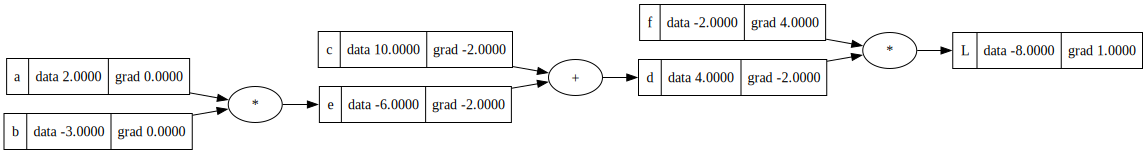

In [15]:
draw_dot(L)

## Manual Backpropagation for the above diagram; example 1: simple expression 

L = d * f

dL/dd = f; dL/df = d 
Why? This is for dL/dd

=>(f(x+h)-f(x))/h 

=>((d+h)*f - d*f) / h

=>(d*f + h*f - d*f) / h

=>(hf)/h

=>f

<hr><hr>

dL/dc = dL/dd * dd/dc & dL/de = dL/dd * dd/de

dL/dd=-2 ; dd/dc = 1.0 ; dd/de = 1.0

d = c + e

=>(f(x+h) + f(x)) / h

=>((c+h + e) - (c+e)) / h

=>(c + h + e - c - e) / h

=>h/h

=>1.0

<br><br>

dL/da = dL/de * de/da & dL/db = dL/de * de/db

dL/de = -2 ; de/da = b; de/db = a;

e = a * b
After differentiating, you'll get b and a respectively (Just like the first one)

## Manual Backpropagation example 2: A NEURON

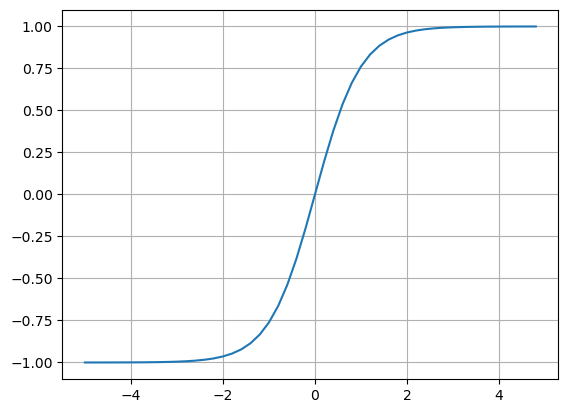

In [16]:
plt.plot(np.arange(-5,5,0.2),np.tanh(np.arange(-5,5,0.2)))
plt.grid()
plt.show()

In [17]:
#inputs x1,x2
x1 = Value(2.0, label='x1')
x2 = Value(0.0, label='x2')
# weights w1,w2
w1 = Value(-3.0, label='w1')
w2 = Value(1.0, label='w2')
# Bias of the neuron
b = Value(6.8813735128987545, label='b')
# x1*w1 + x2*w2 + b
x1w1 = x1*w1; x1w1.label = 'x1w1'
x2w2 = x2*w2; x2w2.label = 'x2w2'
x1w1x2w2 = x1w1 + x2w2; x1w1x2w2.label = 'x1w1x2w2'
n = x1w1x2w2 + b; n.label='n'
# -----
e = (2*n).exp()
o = (e - 1) / (e + 1)
# ------
o.label='o'


In [18]:
# o.grad = 1.0
# # o = tanh(n)
# # do/dn = 1 - tanh(n)**2 = 1-o**2 = 0.5
# n.grad = 1 - (o.data**2)
# # do/dx1w1x2w2 = do/dn * dn/dx1w1x2w2 = 0.5 * 1 (The derivative is 1 beacause of the + sign between the 2; equal distribution)
# # do/db = do/dn * dn/db = 0.5 * 1
# x1w1x2w2.grad = n.grad * 1
# b.grad = n.grad * 1
# # do/dx1w1 = do/dx1w1x2w2 * dw1x1x2w2/dx1w1 = 0.5 * 1
# # do/dx2w2 = do/dx1w1x2w2 * dw1x1x2w2/dx2w2 = 0.5 * 1
# x1w1.grad = x1w1x2w2.grad * 1
# x2w2.grad = x1w1x2w2.grad * 1
# # do/dw1 = do/x1w1 * dw1x1/dw1 = 0.5 * -3
# # do/dw2 = do/x2w2 * dw2x2/dw2 = 0.5 * 0
# x2.grad = w2.data * x2w2.grad
# w2.grad = x2.data * x2w2.grad 
# x1.grad = w1.data * x1w1.grad
# w1.grad = x1.data * x1w1.grad

## Implementing the backword fucntion for each operation

Done in the Value Class

And we don't have to do it manually; we just need to call the function of each node

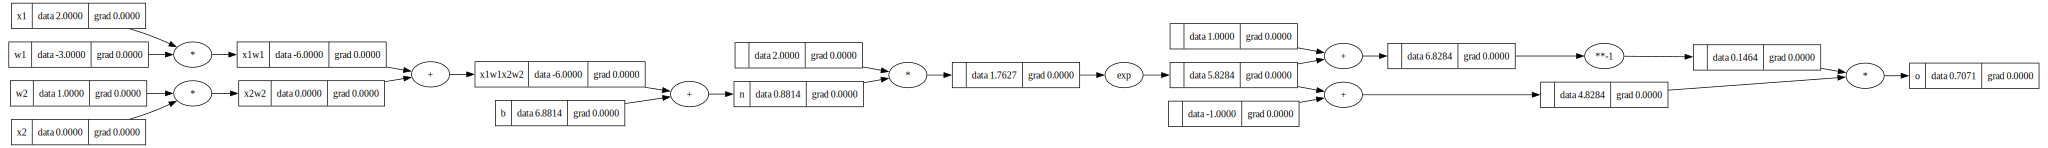

In [19]:
draw_dot(o)

In [20]:
# o._backward()
# n._backward()
# b._backward()
# x1w1x2w2._backward()
# x1w1._backward()
# x2w2._backward()

## Implementing the backward function for a whole expression graph

In [21]:
o.backward()

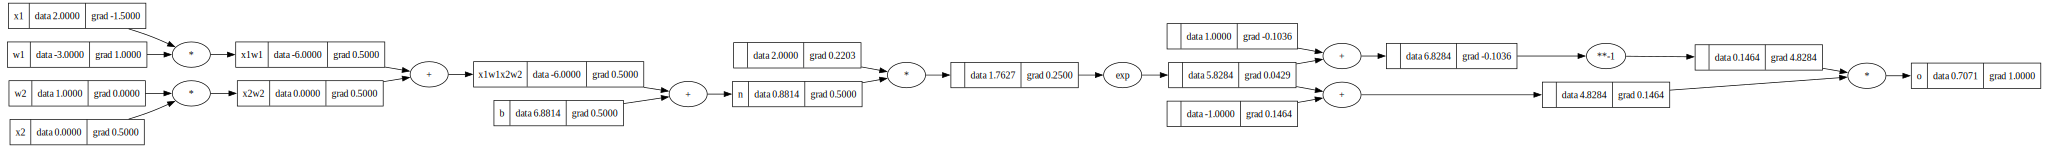

In [22]:

draw_dot(o)

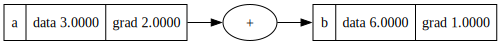

In [23]:
# Fixing  backprop bug when one node is used multiple times
a = Value(3.0, label='a')
b = a+a; b.label='b'
b.backward()
draw_dot(b)
# Here there are 3 arrows coming out of a, but the gradient is not correct
# So instead of setting the gradients we need to accumilate them; so += instead of = in the _backward functions

## Breaking up tanh, excercising with more operations

In [24]:
# Added / - pow and exponent functions to the Value class
# This represents the inner workings if the previous tanh function we had made

## Implementing the same thing but in PyTorch

In [25]:
import torch
import random

In [26]:
x1 = torch.Tensor([2.0]).double() ; x1.requires_grad = True
x2 = torch.Tensor([0.0]).double() ; x2.requires_grad = True
w1 = torch.Tensor([-3.0]).double() ; w1.requires_grad = True
w2 = torch.Tensor([1.0]).double() ; w2.requires_grad = True
b = torch.Tensor([6.88137535870195432]).double() ; b.requires_grad = True
n = x1*w1 + x2*w2 + b
o = torch.tanh(n)

print(o.data.item())
o.backward()
print('-----')
print('x2', x2.grad.item())
print('w2', w2.grad.item())
print('x1', x1.grad.item())
print('w1', w1.grad.item())

0.707107644078311
-----
x2 0.4999987796860207
w2 0.0
x1 -1.499996339058062
w1 0.9999975593720414


## Building out a Neural Net Library (Multi-layer perceptron) in micrograd

In [447]:
class Neuron:
    def __init__(self, nin):
        self.w = [Value(random.uniform(-1,1)) for _ in range(nin)]
        self.b = Value(random.uniform(-1,1))
    def __call__(self, x):
        # w*x + b
        act = sum((wi*xi for wi, xi in zip(self.w, x)), self.b)
        out = act.tanh()
        return out
    def parameters(self):
        return self.w + [self.b]

class Layer:
    def __init__(self, nin, nout):
        self.neurons = [Neuron(nin) for _ in range (nout)]
    def __call__(self,x):
        outs = [n(x) for n in self.neurons]
        return outs[0] if len(outs) == 1 else outs
    def parameters(self):
        return [p for neuron in self.neurons for p in neuron.parameters()]
        # params = []
        # for neuron in self.neurons:
        #     ps = neuron.paramerters()
        #     params.extend(ps)
        # return params
    
class MLP:
    def __init__(self, nin, nouts):
        sz = [nin] + nouts
        self.layers = [Layer(sz[i], sz[i+1]) for i in range(len(nouts))]
    def __call__(self,x):
        for layer in self.layers:
            x = layer(x)
        return x
    def parameters(self):
        return [p for layer in self.layers for p in layer.parameters()]
        

In [448]:
x = [2.0, 3.0, -1.0]
n = MLP(3, [4,4,1])
n(x)

Value(data=0.8615772179067277)

In [449]:
len(n.parameters())

41

## Creating a small dataset and writing the loss function

In [450]:
xs = [
    [2.0, 3.0, -1.0],
    [3.0, -1.0, 0.5],
    [0.5, 1.0, 1.0],
    [1.0, 1.0, -1.0]
]
ys = [1.0, -1.0, -1.0, 1.0] # Desired targets

In [451]:
for k in range(1000):
    # Forward Pass
    ypred = [n(x) for x in xs]
    loss = sum(((yout - ygt)**2 for ygt, yout in zip(ys, ypred)), Value(0))
    loss
    # Backward Pass
    for p in n.parameters(): #Zero Grad must be done
        p.grad = 0.0
    loss.backward()
    # Update Gradient descent
    for p in n.parameters():
        p.data += -0.05 * p.grad
        
    if k % 10 == 0:
        print(k, loss.data)

0 4.169550451672086
10 0.10362132865746587
20 0.0443899248267349
30 0.027535439354299494
40 0.01976905774606979
50 0.015347501409170513
60 0.0125082308825864
70 0.010537195639702478
80 0.009092020364096775
90 0.007988655562404046
100 0.00711959239241303
110 0.006417932102850954
120 0.005839919659064505
130 0.00535576045815829
140 0.004944479582704119
150 0.004590892361760219
160 0.004283740886709256
170 0.0040145052658098045
180 0.0037766212234539
190 0.003564950964699219
200 0.0033754166929229066
210 0.0032047413755401603
220 0.0030502618967521555
230 0.002909792097658735
240 0.0027815208479695635
250 0.002663935137529178
260 0.0025557613140988087
270 0.0024559196681066733
280 0.0023634889613468246
290 0.0022776784523085942
300 0.0021978056350697005
310 0.0021232783769381935
320 0.002053580474454532
330 0.0019882598891261126
340 0.001926919101018362
350 0.0018692071489167165
360 0.0018148130232103524
370 0.0017634601510207863
380 0.001714901768829315
390 0.001668917020533435
400 0.001

## Doing Gradient Descent Optimization manually, training the network

In [452]:
## The above for loop is the one
ypred

[Value(data=0.9904020086806983),
 Value(data=-0.9922639084940834),
 Value(data=-0.9844726566954909),
 Value(data=0.9846282426605587)]